[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/howesa/CHI22-CogMod-Tutorial/blob/main/04-Go_Nogo/04_Go_Nogo.ipynb)


In [1]:
# Install the files to local
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/animate_trace.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/driver_agent_physics.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/go_nogo.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/physics_env.py

--2023-04-21 12:02:52--  https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/blob/main/04-Go_Nogo/animate_trace.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-04-21 12:02:53 ERROR 404: Not Found.

--2023-04-21 12:02:53--  https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/blob/main/04-Go_Nogo/driver_agent_physics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-04-21 12:02:53 ERROR 404: Not Found.

--2023-04-21 12:02:53--  https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/blob/main

In [ ]:
# Install the required libraries.
! pip install --pre -U stable_baselines3
! pip install gym
! pip install shimmy

# Module 4: Building a Model

In this module, we take a step-by-step walktrough of how to create a computational rational (CR) model using deep reinforcement learning (RL). This notebook does not cover the full workflow of CR modeling, which is long and detailed. It can be found here, make sure to follow it when creating your own models. For the purpose of this notebook, the simplified workflow looks like this:

1. Define the goals.

2. Define the environment.

3. Define the cognitive limitations.

4. Derive the optimal behavior.

5. Inspect model validity.

The model will be defined according to the standard CR flow of information.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/corati_model.png" alt="Corati Modeling" width="700">


# 1. Define the agent's goals

The task explored in this notebook is a fairly simple one: in a junction, when turning against the oncoming traffic, the driver needs to decide if they can go, or if they need to wait for an oncoming car before they can cross. In left-handed traffic, this means that the agent driver is turning right. Here is the illustration:

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/go_nogo_task.png" alt="Go / No go task" width="300">

The agent (the yellow car) has two main goals:

1. Proceed to the destination by turning left.

2. Drive safely, avoiding collisions.

First, we need to analyze these goals. First, the agent wants to drive efficiently and not get stuck on the road for too long. They probably want to get to their destination, and also they would be blocking the traffic behind them if they wait unreasonably long. So we can analyse these goals into a reward function.

1. When the agent turns left successfully, there is a positive reward.
2. For this positive reward, there is a penalty of time spent waiting.
3. For a collision, there is a negative reward.

# 2. Define the task environment

For simplicity, the environment has only two cars, in a 2-dimensional environment: the agent's car and the oncoming car. The cars are particles that have their individual `(x,y)` coordinates. The agent's car is stationary until the agent decides to turn left. The oncoming car has a variable position, which moves along the y-axis of the environment according to its velocity, which is fixed constant. A collision is detected if the vehicles are too close to each other regardless of their velocities.

# 3. Define the relevant cognitive bounds of the agent

The agent must make a decision to go (turn left) or wait. It bases this decision on a noisy observation of the oncoming car's distance to the agent's car. If the distance is long enough, the agent can go and save time. If the car is too close, the agent must wait for it to pass to avoid a collision.

For modeling noisy observation, we will be using the formula from Markkula, et al. (2022). Explaining human interactions on the road requires large-scale integration of psychological theory. https://psyarxiv.com/hdxbs/

$ \hat{D} = D_{oth} \cdot \left(1 - \frac{h}{D \cdot \tan \left(\arctan \left(\frac{h}{D}\right) + \sigma \right)}\right) $,

where $ \hat{D} $ is a noisy observation of distance, $D_{oth}$ is the oncoming car's longitudinal distance to the crossing point, and $h$ is the observer's eye height over ground (1.5m). The important parameter here is $\sigma$, which describes how noisy the observation is.

The noisy observation is not used directly, but via Bayesian filtering. This considers prior belief about the distance and integrates the new observation with it. Additionally, we represent the uncertainty associated with the belief.

Before deriving the optimal behavior, we want to establish what hypotheses our model in fact makes, so that we can then assess the plausibility of model predictions against them. While modeling is virtually always interactive and the hypotheses might develop during iteration, but it is important to have a strong initial assumption about how our model will behave. Here are initial proposals, which would then be turned into exact, testable hypotheses:

P1. For a non-noisy (full) observer, there is a precise distance: if the other car is farther than this distance, the agent decides to go. If the other car is closer, the agent chooses to wait. If the car has passed, the agent always goes.

P2. For a noisy (partial) observer, the decision to go is more conservative and uncertain: the distance that determines the go / no go decision is larger, and due to noisy estimates, the choice is probabilistic given distance.

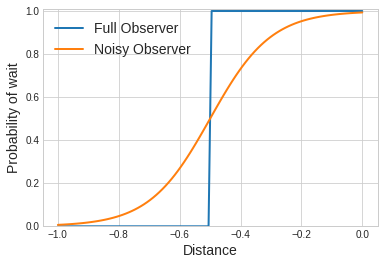

In [24]:
# Here is a theoretical illustration of our proposals.
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
x1 = np.linspace(-1, 0, 100)
x2 = np.linspace(-1, 0, 100)
y1 = np.zeros(100)
y1[50:] = 1
y2 = 1 / (1 + np.exp(-10*(x2+0.5)))
plt.plot(x1, y1, label='Full Observer', linewidth = 2)
plt.plot(x2, y2, label='Noisy Observer', linewidth = 2)
plt.ylim(0, 1.01)
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Probability of wait', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# 4. Derive optimal policy

For establishing the (bounded) optimal policy for the ideal and noisy observer agents, we will be using Proximal Policy Optimization, which is an on-policy deep RL algorithm. This notebook uses the OpenAI Stable Baselines implementation, but there are others as well. https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

Before we can derive the optimal policy, the environments (both internal and external) need to be modeled using Markov Decision Process (MDP, or in our case, due to partial observability, we are defining a POMDP). We won't go into the details of how the external driving environment is modeled, but it is a simple stepwise simulator, that for each time step (0.05 seconds by default), "ticks" the environment forward by moving the upcoming car's y-position according to its velocity, and in case the agent decides to go, moves it towards the side road along a predefined trajectory, in a constant velocity as well.

For the internal environment, we need to model the belief update for distance of the oncoming car, given the equation and filtering that were defined above. All relevant information must be represented as the agent's belief such that we can pass that, along with the reward signal, to the RL agent for learning the optimal policy.

In [2]:
# Here are the action and observation spaces of the agent

from gym.spaces import Discrete, Dict, Box

action_space = Discrete(2)        

# Note that all observatons are normalized between 0 and 1.
observation_space = Dict(
    spaces = {
        "distance": Box(0, 1, (1,)),
        "passed": Box(0, 1, (1,)),
        "distance_var": Box(0, 1, (1,)),
        "speed": Box(0, 1, (1,)),
        "acceleration": Box(0, 1, (1,)),
        "ticks": Box(0, 1, (1,))
    })

# Sample the action space:
print("A small sample of actions:", action_space.sample(), action_space.sample(), action_space.sample())
print("One sample of observation space:", observation_space.sample())

A small sample of actions: 1 0 0
One sample of observation space: OrderedDict([('acceleration', array([0.1268193], dtype=float32)), ('distance', array([0.00425035], dtype=float32)), ('distance_var', array([0.54981065], dtype=float32)), ('passed', array([0.63592726], dtype=float32)), ('speed', array([0.7017883], dtype=float32)), ('ticks', array([0.81666183], dtype=float32))])


In [1]:
# Let's define an environment and an agent and see how it works.
import physics_env
import driver_agent_physics

e = physics_env.physics_env()
agent = driver_agent_physics.driver_agent_physics(e, observation_var = 0) # a full observer: no noise
agent.reset()

{'distance': [0.027215512391783197],
 'speed': [0.298],
 'acceleration': [0],
 'passed': [0],
 'distance_var': [0],
 'ticks': [0.0]}

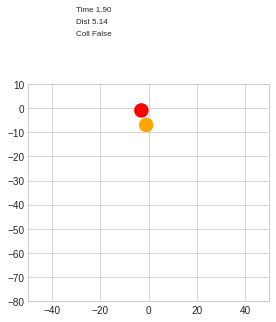

In [18]:
# Let's wait for 20 ticks, then go.
from IPython.display import HTML, display
import animate_trace

agent.reset()
agent.env.save_trace = True
for i in range(20):
    agent.step(0)
agent.step(1)
agent.env.save_trace = False

HTML(animate_trace.animate_trace(agent.env.trace, get_anim = True, x_lim = [-50,50], y_lim = [10,-80]).to_jshtml())

So, the environment simulation works as intended. Let's now take a look at the reward function. Remember our definition:

1. When the agent turns left successfully, there is a positive reward.
2. For this positive reward, there is a penalty of time spent waiting.
3. For a collision, there is a negative reward.

We will establish the reward function along with one step of the model to see what actually happens when we step.

In [5]:
def step(self, action):
    self.reward = 0
    # action: no go
    if action == 0:
        self.env.tick()
        self.ticks += 1
        # break if nothing ever happens
        if self.ticks > self.max_ticks:
            self.reward = -10
            self.done = True
        if self.env.get_distance() > self.max_distance:
            self.reward = -10
            self.done = True                
    # action: go
    if action == 1:
        # Did we wait for the other car before going?
        if self.env.veh2_turn_pos[1] < self.env.veh1_straight_pos[1]:
            self.waited_before_go = True
        self.distance_at_go = self.env.get_distance()
        self.done = True
        self.collision, _ = self.env.simulate_go()
        if self.collision:
            self.reward = -10
        else:
            self.reward = 10 - self.penalty_per_tick * self.ticks

    self.belief = self.get_belief()

    return self.belief, self.reward, self.done, {}

In [2]:
# Let's make and train the full observer agent.
import go_nogo
full_obs_agent = go_nogo.make_agent(sigma = 0, iters = 10)
# In the output:
# i = training iteration
# t = number of ticks (1 tick = 0.05s)
# r = average reward (10 is max)
# d = average distance of the two vehicles at the time of go (in meters)
# w = frequency of waits (agent waited the other car to pass before going)
# c = frequency of collisions


i	t	r	d	w	c
0	1.29	0.58	16.46	0.0	0.47
1	1.29	1.38	17.11	0.0	0.43
2	1.42	-1.62	15.97	0.0	0.58
3	1.31	0.99	17.41	0.0	0.45
4	3.08	3.82	15.41	0.09	0.3
5	7.03	5.24	15.27	0.28	0.21
6	11.26	8.58	14.21	0.46	0.02
7	11.81	8.92	14.7	0.45	0.0
8	10.66	8.64	14.03	0.47	0.02
9	10.86	8.42	14.33	0.44	0.03


In [14]:
# To keep training the agent without initializing it anew, use
go_nogo.retrain_agent(full_obs_agent, iters = 10)


i	t	r	d	w	c
0	12.76	8.82	13.13	0.53	0.0
1	9.69	8.53	14.21	0.45	0.03
2	11.96	8.5	13.41	0.51	0.02
3	10.64	8.64	14.4	0.48	0.02
4	10.65	8.84	13.66	0.49	0.01
5	8.73	9.23	15.48	0.39	0.0
6	19.47	7.95	16.47	0.46	0.01
7	19.39	7.76	18.09	0.41	0.02
8	18.88	7.81	17.7	0.42	0.02
9	21.41	7.56	17.17	0.46	0.02


(1, 10.0, 16.556456444541507, 0, 0)


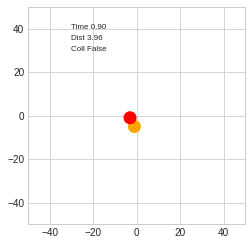

In [19]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(full_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

In [3]:
# Train the noisy observer
noisy_obs_agent = go_nogo.make_agent(sigma = 0.1, iters = 10)


i	t	r	d	w	c
0	1.91	1.15	16.08	0.0	0.44
1	1.81	-2.82	14.79	0.0	0.64
2	2.2	0.73	15.68	0.02	0.46
3	3.61	2.99	15.23	0.09	0.34
4	7.51	3.84	13.38	0.3	0.28
5	8.31	4.36	15.0	0.29	0.25
6	9.16	6.82	14.5	0.38	0.12
7	9.39	5.77	13.55	0.43	0.17
8	9.44	6.58	14.48	0.4	0.13
9	9.59	6.55	14.97	0.36	0.13


In [15]:
# To keep training the agent without initializing it anew, use
go_nogo.retrain_agent(noisy_obs_agent, iters = 10)


i	t	r	d	w	c
0	10.7	7.84	15.4	0.4	0.06
1	11.54	7.35	13.54	0.48	0.08
2	12.73	7.65	13.45	0.49	0.06
3	11.09	8.0	13.97	0.48	0.05
4	11.86	6.92	13.15	0.51	0.1
5	11.09	8.0	13.87	0.48	0.05
6	11.67	7.15	14.53	0.43	0.09
7	11.23	7.79	13.68	0.51	0.06
8	11.84	7.72	12.98	0.53	0.06
9	10.37	7.27	13.37	0.46	0.09


(36, 6.5, 5.738625690064304, 1, 0)


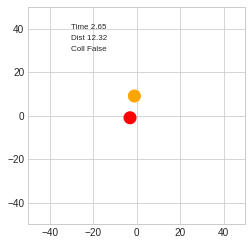

In [20]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(noisy_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

In [21]:
# Run an experiment for obtaining multiple samples from each agent.
def wait_or_go_experiment(agent, y_range, n = 100, deterministic = False):
    data = []
    agent.env.veh1_straight_start_y_range = y_range
    for i in range(n):
        _, _, _, w, c = agent.run_episode(deterministic = deterministic)
        data.append([agent.observation_var, agent.env.y_start, w, c])
    
    agent.env.veh1_straight_start_y_range = [-25,-2] # return back to original
    return data

import pandas as pd

data = wait_or_go_experiment(full_obs_agent, y_range = [-5,-25], n = 200, deterministic = True)
data = data + wait_or_go_experiment(noisy_obs_agent, y_range = [-5,-25], n = 200, deterministic = True)
columns = ['sigma', 'y_start', 'wait', 'collision']
df = pd.DataFrame(data, columns=columns)

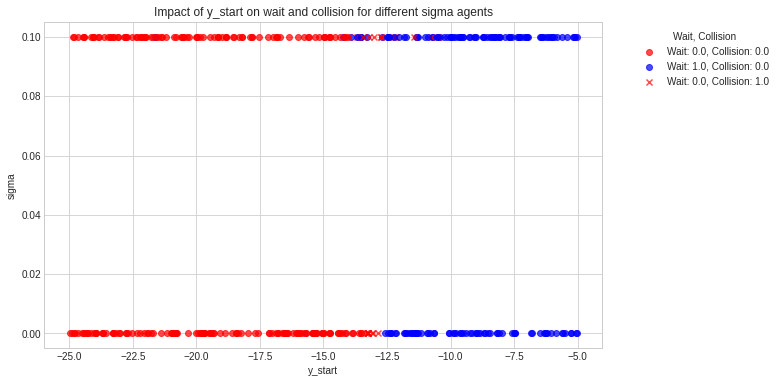

In [22]:
# Visualize individual go/no go decisions between different sigma models for various y_ranges.

import numpy as np
import matplotlib.pyplot as plt

# Note: this is a bit slow and dirty, gets slow with a lot of data. Only use for diagnosis.
def plot_data(df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define custom colors and markers based on wait and collision values
    colors = {0: 'red', 1: 'blue'}
    markers = {0: 'o', 1: 'x'}

    # Create a dictionary to store the labels we've already added to the legend
    labels_added = {}

    for index, row in df.iterrows():
        sigma = row['sigma']
        y_start = row['y_start']
        wait = row['wait']
        collision = row['collision']
        label = f'Wait: {wait}, Collision: {collision}'

        # Add scatter plot point with custom color and marker
        ax.scatter(
            y_start,
            sigma,
            marker=markers[collision],
            color=colors[wait],
            label=label if label not in labels_added else "",
            alpha=0.7
        )
        
        # Remember that we've added this label to the legend
        labels_added[label] = True

    ax.set_xlabel('y_start')
    ax.set_ylabel('sigma')
    ax.legend(title="Wait, Collision", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Impact of y_start on wait and collision for different sigma agents')
    plt.show()
    
plot_data(df)

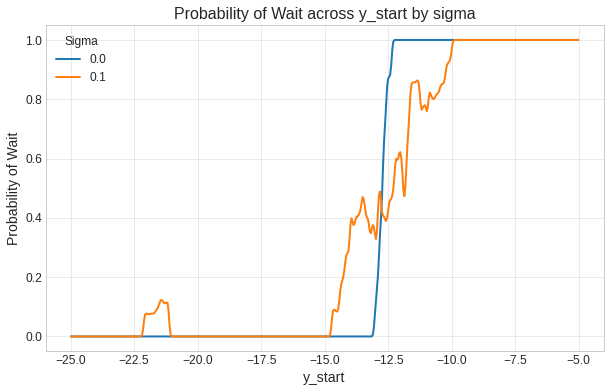

In [23]:
# Visualize the probability of go/no go as the function of y_start, between different sigmas.

# Change smoothness to larger to get less raggedy lines.
smoothness = 1

from scipy.ndimage import gaussian_filter1d

def estimate_probability(df, sigma, y_start_values, window_size=1, collision = False):
    sub_df = df[df['sigma'] == sigma].sort_values('y_start')
    probabilities = []

    for y_start in y_start_values:
        window_df = sub_df[(sub_df['y_start'] >= y_start - window_size / 2) & (sub_df['y_start'] <= y_start + window_size / 2)]
        probability = window_df['collision' if collision else 'wait'].sum() / len(window_df)
        probabilities.append(probability)

    return probabilities

def smooth_probabilities(probabilities, sigma=1):
    return gaussian_filter1d(probabilities, sigma=sigma)

def plot_probability_lines(df, collision = False):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    y_start_range = np.linspace(df['y_start'].min(), df['y_start'].max(), num=500)

    for sigma in df['sigma'].unique():
        probabilities = estimate_probability(df, sigma, y_start_range, collision = collision)
        smoothed_probabilities = smooth_probabilities(probabilities, sigma = smoothness)
        ax.plot(y_start_range, smoothed_probabilities, label=f'{sigma}', linewidth=2)

    ax.set_xlabel('y_start', fontsize=14)
    ax.set_ylabel('Probability of Wait', fontsize=14)
    ax.legend(title="Sigma", loc="upper left", fontsize=12, title_fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Probability of Wait across y_start by sigma', fontsize=16)
    plt.grid(alpha=0.5)
    plt.show()

plot_probability_lines(df)